In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import datetime
import datetime as dt
import numpy as np
import random
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import PercentFormatter
from scipy.stats import norm
import quandl
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
sns.set_style("ticks")

In [2]:
# Quandl API calls
import sys
import os 
quandl.ApiConfig.api_key = "1FHran9s_sz2z6Vxgkvy"

#Benchmark S&P 500 Data - Can't be pulled from Quandl.
sp5001 = pd.read_csv("sp500.csv")
sp500 = sp5001["Close"]


def equalizer(lists):
    '''
    We want all of these lists to be the length of the shortest list.
    '''
    lengths = []
    for li_st in lists:
        lengths.append(len(li_st))
    length = min(lengths)
    new_lists = []
    for li_st in lists:
        new_lists.append(li_st[0:length])
    return new_lists

'''
Stock_Data, ECB_DATA, and Fred_Data are functions that take in a dictionary of assets with corresponding with their labels,
the main difference between the functions is the quandl code. Different databases have different codes to access information.

Inputs: Dictionary of assets with corresponding labels.

Returns: DF with all assets in dictionary combined and labeled properly. List of strings labels for asset.

'''

#Equity Data From Quandl
def Stock_Data(tickers):
    stocks = []
    stock_labels = []
    for i,k in tickers.items():
        WIKI_string = ("WIKI/"+i)
        data = quandl.get(WIKI_string,start_date="2015-1-17", end_date="2018-11-15")  #QUANDL Call, pulls from API
        array = np.array(data.iloc[:,3])
        stocks.append(array)
        stock_labels.append(k)

    stocks = equalizer(stocks)

    stock_twoD = np.column_stack(stocks)
    stocks_DF = pd.DataFrame(stock_twoD,columns=stock_labels)
        
    return stocks_DF, stock_labels

stock_basket = {"LUV":"Southwest Airlines", "INTC":"Intel", "AMZN":"Amazon", "GS":"Goldman Sachs", "AAPL":"Apple", "MSFT":"Microsoft",
               "JPM":"Morgan", "GOOG":"Google", "CSCO":"Cisco","C":"Citi"}
stock_portfolio, stock_labels = Stock_Data(stock_basket)
stock_portfolio.head()

#Currencies
tickers = ("EURAUD","EURMXN",'EURUSD','EURTRY')
def ECB_Data(tickers):
    '''
    Pulls in data using quandl Euro Central Bank database
    '''
    ecb_pairs = []
    for i in tickers:
        x = ("ECB/"+i)
        data = quandl.get(x,start_date="2015-1-17", end_date="2018-11-15")
        array = np.array(data)
        ecb_pairs.append(array)
    return ecb_pairs



def fred_data(tickers):
    '''
    Pulls in data using quandl FRED Database.
    '''
    fred_pairs = []
    fred_labels = []
    for i,k in tickers.items():
        fred_string = ("FRED/"+i)
        data = quandl.get(fred_string,start_date="2015-1-17", end_date="2018-11-15")
        array = np.array(data)
        fred_pairs.append(array)
        fred_labels.append(k)

    two_d_pairs = np.column_stack(fred_pairs)
    fred_pairs_DF = pd.DataFrame(two_d_pairs,columns=fred_labels)
        
    return fred_pairs_DF, fred_labels

fred_tickers = {"DEXUSAL":"AUD/USD","DEXUSUK":"GBP/USD", "DEXCAUS": "USD/CAD", "DEXUSEU": "EUR/USD", "DEXJPUS": "USD/JPY", "DEXMXUS":"USD/MXN"}
fred_pairs,fred_labels = fred_data(fred_tickers)
#fred_pairs.head(10)


In [3]:

def zero(basket):
    '''
    Because our strategies do not have to buy or sell everyday, if we compare a portfolio ran through our strategy 
    it will most likely be different lengths.

    This function will add zeros to every column to match the length of the longest column. 

    Returns: A 2D array with the same length of columns.
    '''
    
    data  = np.copy(basket)
    hold = []
    for i in range(len(data)):
        lens = len(data[i])
        hold.append(lens)
    max_length = np.max(hold)
    for i in range(len(data)):
        while len(data[i]) <= max_length-1:
            replaced = np.insert(data[i],len(data[i]),0)
            data[i] = replaced
    stacked = np.column_stack(data)
    return stacked


def combine(structured_rets):
    '''
    Combine function takes in the 2D array with zeros from the zero function, and averages the results from each row.
    If there are zeros in the row, the function will only take the average of non zero numbers. 

    Returns: A 1D array of the running sum of the mean of each rows.
    
    '''
    combined_returns = []
    for i in range(len(structured_rets)):
        num_zeros = (structured_rets[[i],:] == 0).sum()
        column_sum = sum(structured_rets[i])
        length = len(structured_rets[i])
        average = column_sum/(length)
        combined_returns.append(average)
    
    running_sum = np.cumsum(combined_returns)
    return combined_returns




def percent_return(data):
    '''
    Input: Array of prices
    Output: Percent Returns * 100 
    '''
    x = []
    for i in range(len(data)-1):
        rets = (data[i+1]-data[i])/data[i]
        x.append(rets)
    return x*100
        

In [4]:
def tester(price_in,technical,long_or_short):
    
    '''
    Tests the MACD indicator across the inputted prices. Long_or_short is where ou can
    specify if you are using a short or a long strategy.
    
    Inputs:
    
    Price_in: Pandas df of price data
    technical: MACD indicator value
    Long_or_short: Indicates whether you are testing the long or short strategy
    
    Returns: 
    
    End return: Is risk adjusted final return - 1 number 
    Total return: Cumulative sum of returns for strategy
    max/min for MACD: 15 and 85 percintile values for MACD - this is to ensure we never have a result that buys every time.


    ''' 
    
   

    buys = []
    shorts = []
    rets = []
    s_rets = []
    benchmark = []
    twenty_six = price_in.ewm(span=26).mean()
    twelve = price_in.ewm(span=12).mean()
    macd = twelve - twenty_six
    delta_macd = macd.pct_change(periods=2)
    slope = []

    if long_or_short == "long":
        for i in range(len(price_in)-1):
            if delta_macd[i] > technical:
                buys.append(i)
    else:
        for i in range(len(price_in)-1):
            if delta_macd[i] < technical:
                shorts.append(i)
    for i in buys:
        j = int(i)
        j1 = int(i+1)
        returns = ((price_in[j1] - price_in[j])/price_in[j])*100
        rets.append(returns)
    for i in shorts:
        s = int(i)
        s1 = int(i+1)
        s_returns = ((price_in[s1] - price_in[s])/price_in[s])*-100
        s_rets.append(s_returns)
    
#    plt.plot(np.cumsum(rets))
    if long_or_short == "long":
        total_return = np.cumsum(rets)
        std_rets = np.std(rets)
        end_return1 = total_return[-1]
        mean_returns = np.mean(rets)
        VAR_95 = (norm.ppf(1-0.95,mean_returns, std_rets))*-1
        end_return = (end_return1)/VAR_95
        
    else:
        total_return = np.cumsum(s_rets)
        end_return = total_return[-1]
        std_s_rets = np.std(s_rets)
        end_return1 = total_return[-1]
        mean_returns = np.mean(s_rets)
        VAR_95 = (norm.ppf(1-0.95,mean_returns, std_s_rets))*-1
        end_return = (end_return1)/VAR_95

    max_macd = np.percentile(delta_macd[5:],85)
    min_macd = np.percentile(delta_macd[5:],15)

    return end_return, total_return, min_macd, max_macd

def random_walker(n,ls,close):
    '''
    A function to randomly select n different values which are all tested and compared to find the best indicator
    We start with a baseline where the indicators = 0. And then pick a new random indicator level and run it back through
    the tester function which returns the end risk adjusted return. If that new return is higher than the baseline, the
    new return becomes the baseline.
    
    After n iterations it will return the best indicator value that produced the highest risk adjusted return.
    
    '''
    starter = [0]    
    test_return, indicator, min_ind, max_ind = tester(close,starter[-1],str(ls))
    for i in range(n):
        test_x = np.random.uniform(min_ind,max_ind)
        random_return, indicator, minn,maxx = tester(close,test_x,str(ls))
        if random_return > test_return:
            starter.append(test_x)
            test_return, notimportant, minn,maxx = random_return, indicator, minn,maxx
#     x,y,minn,maxx = tester(close,starter[-1],str(ls))
        
    return starter[-1]

In [5]:
def back_testing(price_in,long_indicator,short_indicator):
    
    '''
    This function takes in an array of price data, with long and short indicator.
    
    '''
    buys = []
    shorts = []
    rets = []
    s_rets = []
    benchmark = []
    twenty_six = price_in.ewm(span=26).mean()
    twelve = price_in.ewm(span=12).mean()
    macd = twelve - twenty_six
    delta_macd = macd.pct_change(periods=2)
    mix = []
    mix_port = []
    slope = []
    for i in range(len(macd)):
        if i == 0:
            slope.append(i)
        else:
            temp_slope = macd[i]-macd[i-1]
            slope.append(temp_slope)

    for i in range(len(price_in)-1):
        if delta_macd[i] > long_indicator:
            buys.append(i)
            mix.append(i)
        elif delta_macd[i] < short_indicator:
            shorts.append(i)
            mix.append(i)
    for i in buys:
        j = int(i)
        j1 = int(i+1)
        returns = ((price_in[j1] - price_in[j])/price_in[j])*100
        rets.append(returns)
    for i in shorts:
        s = int(i)
        s1 = int(i+1)
        s_returns = ((price_in[s1] - price_in[s])/price_in[s])*-100
        s_rets.append(s_returns)

    x_strat = np.linspace(0,1,len(rets))   
    x_short = np.linspace(0,1,len(s_rets))
    mix_port = np.concatenate((rets,s_rets))
    x_mix = np.linspace(0,1,len(mix_port))

    return mix_port



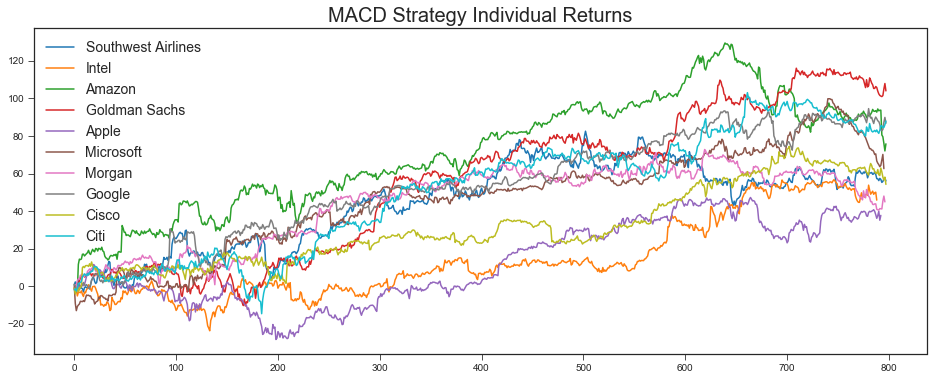

In [6]:
def best_indicator(n,prices,labels):
    '''
    Inputs:
    
    N - amount of random walker iterations
    Prices - Array of prices
    Labels - List of strings labels
    '''
    long_ind = random_walker(n,"long",prices)
    short_ind = random_walker(n,"short",prices)
    returns = back_testing(prices,long_ind,short_ind)
    plt.plot(np.cumsum(returns),label=labels)
    plt.title("MACD Strategy Individual Returns", fontsize=20)
    plt.legend(fontsize=14)
    return returns
plt.figure(figsize=(16,6))

def portfolio_sim(n, portfolio, labels):
    '''
    For every asset in the portfolio we run the random walker to find the best indicator for each asset.
    Plots the best result portfolio performance .
    '''
    basket = []
    for i in range(portfolio.shape[1]):
        column = str(labels[i])
        best_sim = best_indicator(n,portfolio[column], column)
        basket.append(best_sim)
        
    return basket

back_tested_portfolio = portfolio_sim(10,stock_portfolio,stock_labels)
        


Benchmark VAR @ confidence Level = 95% Level -0.064
MACD Strategy VAR @ confidence Level = 95% Level -0.007
Total Strategy Return 65.61
Average Yearly ROI = 17.13


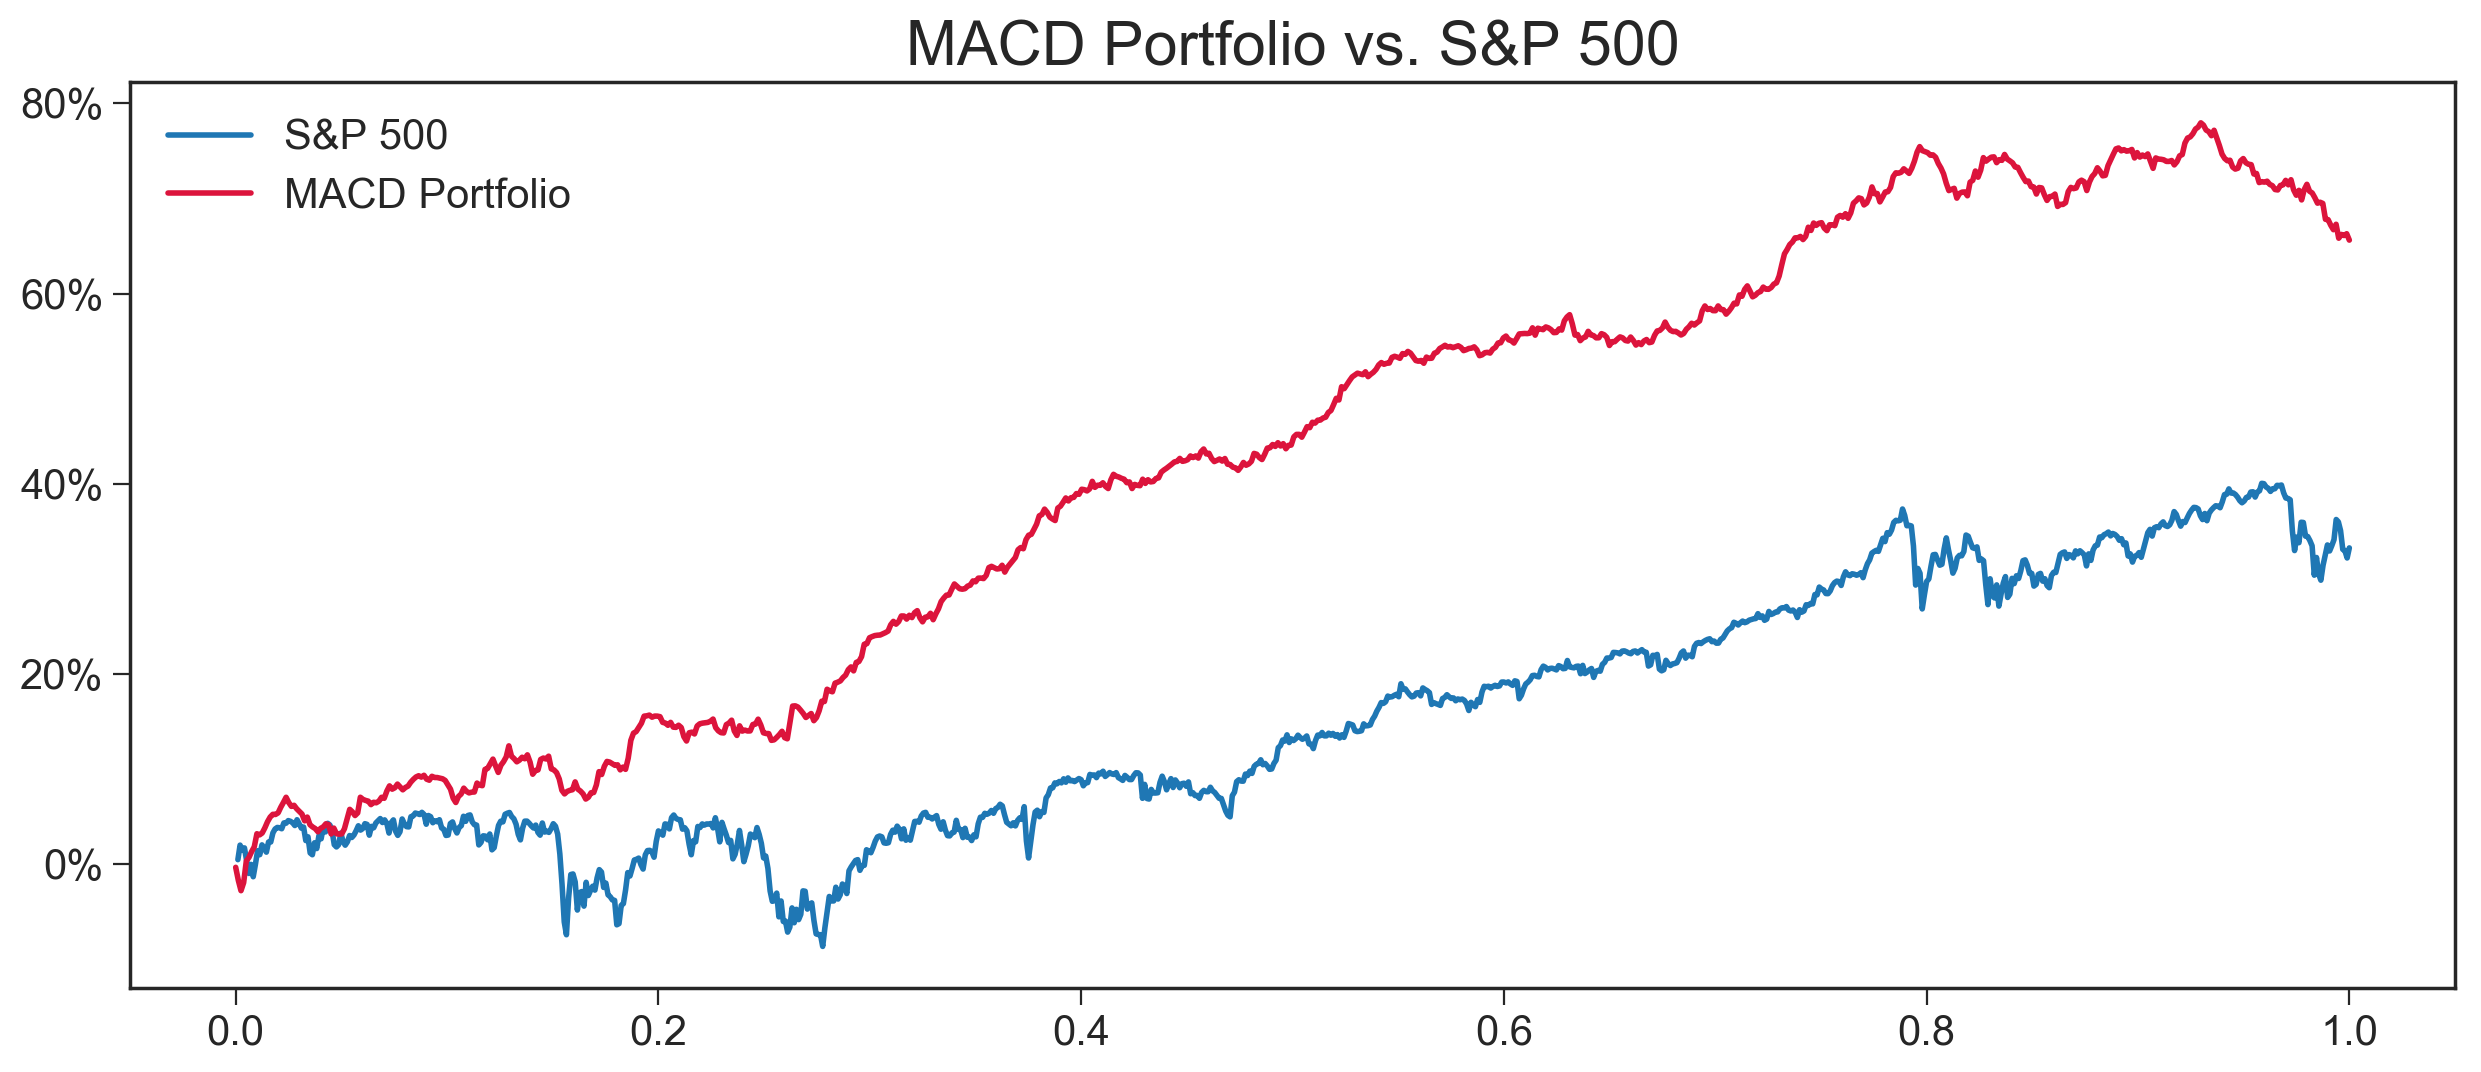

In [7]:
structured_returns = zero(back_tested_portfolio)
total_returns = combine(structured_returns)
cum_returns = np.cumsum(total_returns)


#RISK ASSESMENT
sp500_returns = np.cumsum(sp500.pct_change(1)*100)
sp500_mean = np.mean(sp500_returns)/100

sp500_std = np.std(sp500_returns)/100
sp500_VAR = norm.ppf(1-0.95,sp500_mean, sp500_std)
print("Benchmark VAR @ confidence Level = 95% Level", round(sp500_VAR,3))
strategy_mean = np.mean(total_returns)/100

strategy_std = np.std(total_returns)/100
strategy_VAR = norm.ppf(1-0.95,strategy_mean, strategy_std)
print("MACD Strategy VAR @ confidence Level = 95% Level", round(strategy_VAR,3))



roi = cum_returns[-1]/(3.83)
print("Total Strategy Return",round(cum_returns[-1],2))
print("Average Yearly ROI =",round(roi,2))

bench_date = np.linspace(0,1,len(sp500_returns))
strat_date = np.linspace(0,1,len(cum_returns))
fig, ax = plt.subplots(figsize=(15,6),dpi=200)

ax.plot(bench_date, sp500_returns, label="S&P 500",linewidth=2)
ax.plot(strat_date, cum_returns, label = "MACD Portfolio", linewidth=2,color="crimson")
ax.tick_params(labelsize=15)
ax.set_title("MACD Portfolio vs. S&P 500",fontsize=22)
ax.yaxis.set_major_formatter(PercentFormatter())



ax.legend(fontsize=15)



plt.savefig("Benchmark.png")

## SMA/LMA 

In [8]:
def SMALMAtester(price_in,SMA_ind,LMA_ind,long_or_short):
    
    ''' 
    
    Tests the short term moving average (SMA) and long term moving average (LMA) indicators for the given prices. Can
    specify if you are using a short or a long strategy.
    
    Inputs:
    
    Price_in: Pandas df of price data
    SMA_ind: Window for the short term moving average
    LMA_ind: Window for the short term moving average
    Long_or_short: Indicates whether you are testing the long or short strategy
    
    Returns: End return (risk adjusted), total return, max/min for SMA, max/min for LMA
    
    '''
    
    #create lists of buys, shorts, returns, and calculate the rolling averages (SMA/LMA) for price_in
    buys = []
    shorts = []
    rets = []
    s_rets = []
    benchmark = []
    LMA = price_in.rolling(window=LMA_ind).mean()
    SMA = price_in.rolling(window=SMA_ind).mean()
    diff = SMA - LMA
    delta_MA = diff.pct_change(periods=2)
    
    
    # decides if you are using a long or short strategy and buys or shorts based on input
    if long_or_short == "long":
        for i in range(len(price_in)-1):
            if diff[i] > 0:
                buys.append(i)
    else:
        for i in range(len(price_in)-1):
            if diff[i] < 0:
                shorts.append(i)
                
    # calculates returns for buys/shorts
    for i in buys:
        j = int(i)
        j1 = int(i+1)
        returns = ((price_in[j1] - price_in[j])/price_in[j])*100
        rets.append(returns)
    for i in shorts:
        s = int(i)
        s1 = int(i+1)
        s_returns = ((price_in[s1] - price_in[s])/price_in[s])*-100
        s_rets.append(s_returns)
    
#    plt.plot(np.cumsum(rets))
    if long_or_short == "long":
        total_return = np.cumsum(rets)
        std_rets = np.std(rets)
        end_return1 = total_return[-1]
        mean_returns = np.mean(rets)
        VAR_95 = (norm.ppf(1-0.95,mean_returns, std_rets))*-1
        end_return = (end_return1)/VAR_95
        
    else:
        total_return = np.cumsum(s_rets)
        end_return = total_return[-1]
        std_s_rets = np.std(s_rets)
        end_return1 = total_return[-1]
        mean_returns = np.mean(s_rets)
        VAR_95 = (norm.ppf(1-0.95,mean_returns, std_s_rets))*-1
        end_return = (end_return1)/VAR_95

    #provides mins/maxes for the random walker below for the average windows
    max_SMA = 50
    min_SMA = 5
    max_LMA = 200
    min_LMA = 50

    return end_return, total_return, max_SMA, min_SMA,max_LMA ,min_LMA


In [9]:
def random_walkerSMALMA(n,ls,close):
    
    ''' 
    
    Using a random walker, the function tests the short term moving average (SMA) and long term moving average (LMA) and tries
    find the best one via brute force.
    
    Inputs:
    
    n: Number of iterations
    ls: Either long or short based on what you want to test
    close: Price data
    
    Returns: The best values for the SMA/LMA windows based on the results from the random walker
    
    '''
    #initialize starter values for the walker
    starter = [5] 
    starter2 = [50] #will need two starters to make this work and update functions and the like
    test_return, indicator, max_SMA, min_SMA,max_LMA ,min_LMA = SMALMAtester(close,starter[-1],starter2[-1],str(ls))
    
    # random walker: generates random integers between min/maxes for the SMA/LMA and then appends if they are better than the last
    for i in range(n):
        test_SMA = np.random.randint(min_SMA,max_SMA)
        test_LMA = np.random.randint(min_LMA,max_LMA)
        random_return, indicator, max_SMA, min_SMA,max_LMA ,min_LMA = SMALMAtester(close,test_SMA,test_LMA,str(ls))
        test_return, notimportant, max_SMA, min_SMA,max_LMA ,min_LMA = SMALMAtester(close,starter[-1],starter2[-1],str(ls))
        if random_return > test_return:
            starter.append(test_SMA)
            starter2.append(test_LMA)
            test_return, notimportant, max_SMA, min_SMA,max_LMA ,min_LMA = random_return, indicator, max_SMA, min_SMA,max_LMA ,min_LMA
        
    return starter[-1] , starter2[-1]

#random_walkerSMALMA(3,"long",e_mini)

In [10]:
def back_testingSMALMA(price_in,SMA_ind,LMA_ind,SMA_indshort,LMA_indshort): #may not need the short ind here as they are not used
    
    ''' 
    
    Creates a mixed portfolio and back tests the strategy on price data based on the indicators you provide.
    
    Inputs:
    
    Price_in: Pandas df of price data
    SMA_ind: Window for the short term moving average
    LMA_ind: Window for the short term moving average
    SMA_indshort: Window for the short term moving average #MAY NOT NEED
    LMA_indshort: Window for the short term moving average

    
    Returns: Mixed portfolio returns
    
    '''
        
    buys = []
    shorts = []
    rets = []
    s_rets = []
    benchmark = []
    LMA = price_in.rolling(window=LMA_ind).mean()
    SMA = price_in.rolling(window=SMA_ind).mean()
    diff = SMA - LMA
    delta_MA = diff.pct_change(periods=2)
    mix = []
    mix_port = []
    slope = []
    for i in range(len(diff)):
        if i == 0:
            slope.append(i)
        else:
            temp_slope = diff[i]-diff[i-1]
            slope.append(temp_slope)

    for i in range(len(price_in)-1):
        if diff[i] > 0:
            buys.append(i)
            mix.append(i)
        elif diff[i] < 0:
            shorts.append(i)
            mix.append(i)
    for i in buys:
        j = int(i)
        j1 = int(i+1)
        returns = ((price_in[j1] - price_in[j])/price_in[j])*100
        rets.append(returns)
    for i in shorts:
        s = int(i)
        s1 = int(i+1)
        s_returns = ((price_in[s1] - price_in[s])/price_in[s])*-100
        s_rets.append(s_returns)
        x_strat = np.linspace(0,1,len(rets))   
    x_short = np.linspace(0,1,len(s_rets))
    mix_port = np.concatenate((rets,s_rets))
    x_mix = np.linspace(0,1,len(mix_port))

    return mix_port

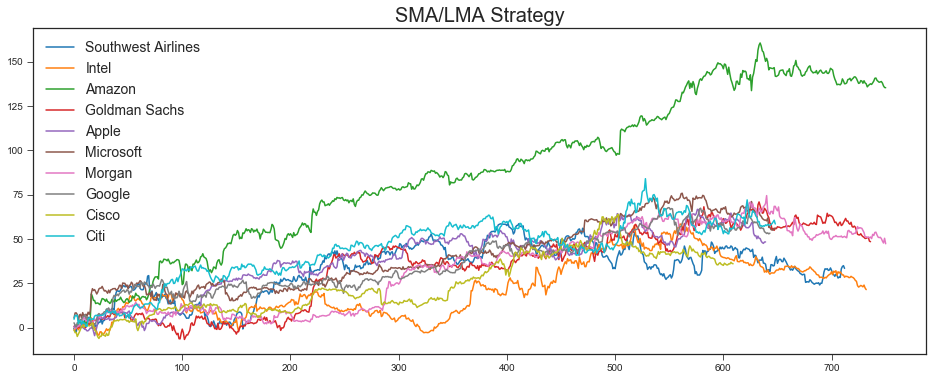

In [11]:
def best_indicatorSMALMA(n,prices,labels):
    
    ''' 
    
    A compilation function for the above functions. Using a random walker and the tester function within random_walker,
    the function tests the short term moving average (SMA) and long term moving average (LMA) and tries
    find the best one via brute force. Then plots the cumulative returns.
    
    Inputs:
    
    n: Number of iterations
    prices: Price data for the security
    labels for each security: Price data
    
    Returns: A plot of the returns as well as the return themselves
    
    '''
    
    #insert random walker function call and code here that simulates different windows for the rolling mean
    SMA,LMA = random_walkerSMALMA(n,"long",prices)
    SMAshort,LMAshort = random_walkerSMALMA(n,"short",prices)
    #back tests based on random walker outputs
    returns = back_testingSMALMA(prices,SMA,LMA,SMAshort,LMAshort)
    #plots the returns and returns the returns
    plt.plot(np.cumsum(returns),label=labels)
    plt.title("SMA/LMA Strategy", fontsize=20)
    plt.legend(fontsize=14)
    return returns
plt.figure(figsize=(16,6))



def portfolio_sim_SMA(n, portfolio, labels):
    ''' 
    
    A compilation function for the above functions which simulates a portfolio for the securities using the best_indicator function.
    
    Inputs:
    
    n: Number of iterations
    portfolio: Price data for various securities
    labels: Labels for the securities
    
    Returns: 
    
    '''
    
    basket = []
    for i in range(portfolio.shape[1]):
        column = str(labels[i])
        best_sim = best_indicatorSMALMA(n,portfolio[column], column)
        basket.append(best_sim)
        
    return basket

sma_strat = portfolio_sim_SMA(50, stock_portfolio, stock_labels)

Benchmark VAR @ confidence Level = 95% Level -0.064
MACD Strategy VAR @ confidence Level = 95% Level -0.007
Total Strategy Return 53.84
Average Yearly ROI = 14.06


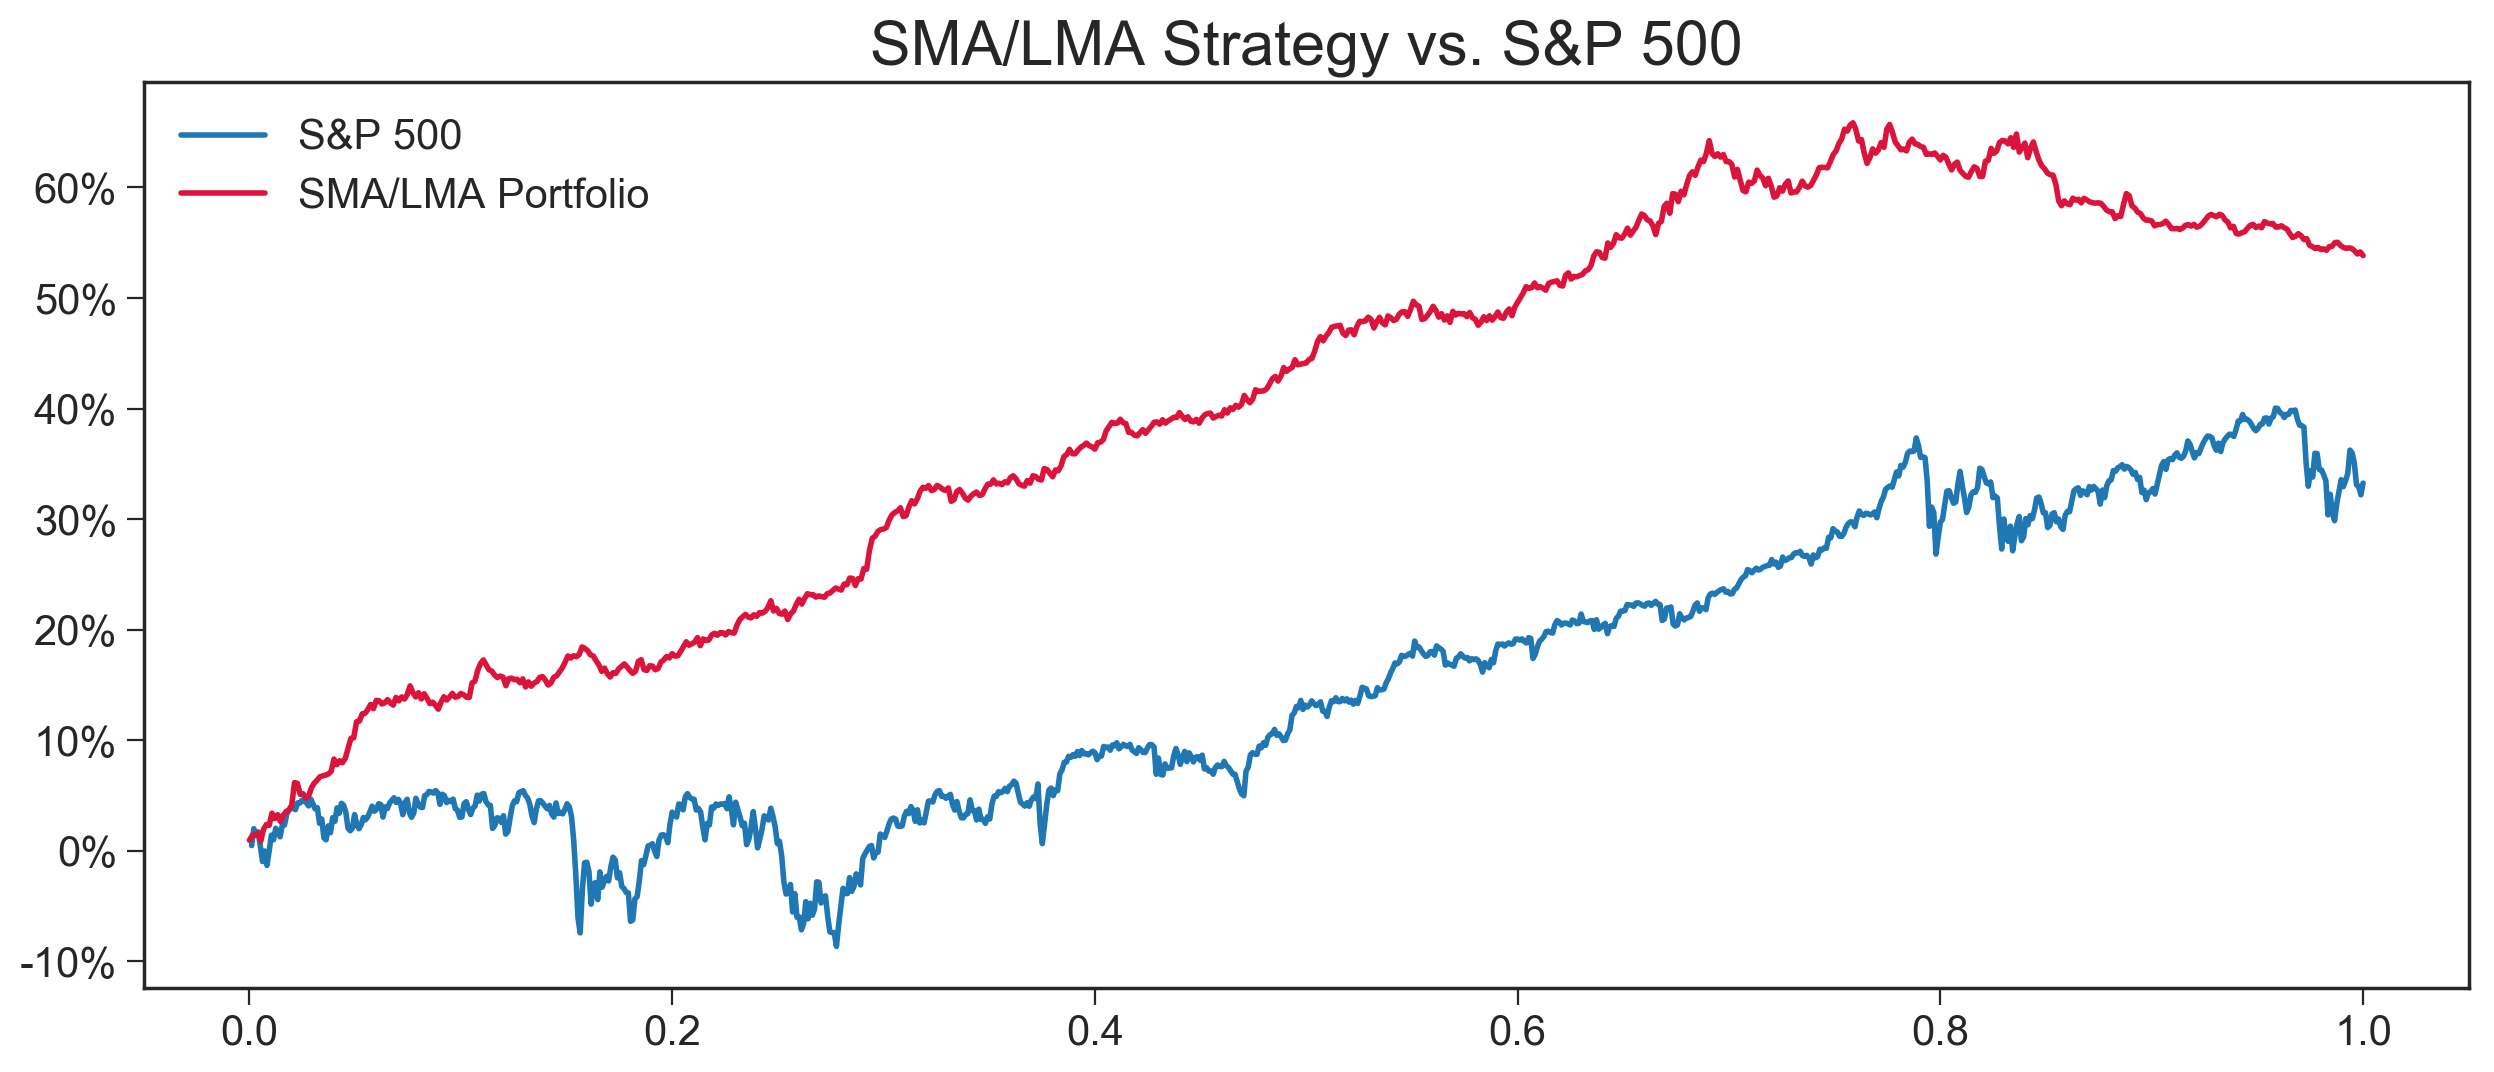

In [12]:
structured_returns = zero(sma_strat)
total_returns = combine(structured_returns)
cum_returns = np.cumsum(total_returns)


#RISK ASSESMENT
sp500_returns = np.cumsum(sp500.pct_change(1)*100)
sp500_mean = np.mean(sp500_returns)/100

sp500_std = np.std(sp500_returns)/100
sp500_VAR = norm.ppf(1-0.95,sp500_mean, sp500_std)
print("Benchmark VAR @ confidence Level = 95% Level", round(sp500_VAR,3))
strategy_mean = np.mean(total_returns)/100

strategy_std = np.std(total_returns)/100
strategy_VAR = norm.ppf(1-0.95,strategy_mean, strategy_std)
print("MACD Strategy VAR @ confidence Level = 95% Level", round(strategy_VAR,3))



roi = cum_returns[-1]/(3.83)
print("Total Strategy Return",round(cum_returns[-1],2))
print("Average Yearly ROI =",round(roi,2))

bench_date = np.linspace(0,1,len(sp500_returns))
strat_date = np.linspace(0,1,len(cum_returns))
fig, ax = plt.subplots(figsize=(15,6),dpi=200)

ax.plot(bench_date, sp500_returns, label="S&P 500",linewidth=2)
ax.plot(strat_date, cum_returns, label = "SMA/LMA Portfolio", linewidth=2,color="crimson")
ax.tick_params(labelsize=15)
ax.set_title("SMA/LMA Strategy vs. S&P 500",fontsize=22)
ax.yaxis.set_major_formatter(PercentFormatter())



ax.legend(fontsize=15)



plt.savefig("Benchmark.png")

In [13]:
def Meantester(price_in,LMA_ind,long_or_short):
    buys = []
    shorts = []
    rets = []
    s_rets = []
    benchmark = []
    mean = price_in.rolling(window=LMA_ind).mean()

    if long_or_short == "long":
        for i in range(len(price_in)-1):
            if price_in[i] < mean[i]:
                buys.append(i)
    else:
        for i in range(len(price_in)-1):
            if price_in[i] > mean[i]:
                shorts.append(i)
    for i in buys:
        j = int(i)
        j1 = int(i+1)
        returns = ((price_in[j1] - price_in[j])/price_in[j])*100
        rets.append(returns)
    for i in shorts:
        s = int(i)
        s1 = int(i+1)
        s_returns = ((price_in[s1] - price_in[s])/price_in[s])*-100
        s_rets.append(s_returns)
    
#    plt.plot(np.cumsum(rets))
    if long_or_short == "long":
        total_return = np.cumsum(rets)
        std_rets = np.std(rets)
        end_return1 = total_return[-1]
        mean_returns = np.mean(rets)
        VAR_95 = (norm.ppf(1-0.95,mean_returns, std_rets))*-1
        end_return = (end_return1)/VAR_95
        
    else:
        total_return = np.cumsum(s_rets)
        end_return = total_return[-1]
        std_s_rets = np.std(s_rets)
        end_return1 = total_return[-1]
        mean_returns = np.mean(s_rets)
        VAR_95 = (norm.ppf(1-0.95,mean_returns, std_s_rets))*-1
        end_return = (end_return1)/VAR_95

    max_M = 100
    min_M = 10

    return end_return, total_return, max_M, min_M


In [14]:
def back_testingMean(price_in,LMA_ind,):
    buys = []
    shorts = []
    rets = []
    s_rets = []
    benchmark = []
    mean = price_in.rolling(window=LMA_ind).mean()


    mix = []
    mix_port = []
    slope = []
    for i in range(len(mean)):
        if i == 0:
            slope.append(i)
        else:
            temp_slope = mean[i]-mean[i-1]
            slope.append(temp_slope)

    for i in range(len(price_in)-1):
        if price_in[i] < mean[i]:
            buys.append(i)
            mix.append(i)
        elif price_in[i] > mean[i]:
            shorts.append(i)
            mix.append(i)
    for i in buys:
        j = int(i)
        j1 = int(i+1)
        returns = ((price_in[j1] - price_in[j])/price_in[j])*100
        rets.append(returns)
    for i in shorts:
        s = int(i)
        s1 = int(i+1)
        s_returns = ((price_in[s1] - price_in[s])/price_in[s])*-100
        s_rets.append(s_returns)

    x_strat = np.linspace(0,1,len(rets))   
    x_short = np.linspace(0,1,len(s_rets))
    mix_port = np.concatenate((rets,s_rets))
    x_mix = np.linspace(0,1,len(mix_port))

    return mix_port


In [15]:

def random_walkerMean(n,ls,close):
    starter = [15]  
    x_start, indicator, max_M, min_M = Meantester(close,starter[-1],str(ls))
    for i in range(n):
        test_M = np.random.randint(min_M,max_M)
        random_return, indicator, max_M, min_M = Meantester(close,test_M,str(ls))
        test_return, notimportant, max_M, min_M = Meantester(close,starter[-1],str(ls))
        if random_return > test_return:
            starter.append(test_M)
    #x,y,minn,maxx = tester(close,starter[-1],starter2[-1],str(ls))
        
    return starter[-1]

In [16]:
def best_indicatorMean(n,prices,labels):
    #insert random walker function call and code here that simulates different windows for the rolling mean
    bestmean = random_walkerMean(n,"long",prices)
    returns = back_testingMean(prices,bestmean) #plugs those here in place of 20/100
    plt.plot(np.cumsum(returns),label=labels)
    plt.legend(fontsize=14)
    return returns
plt.figure(figsize=(15,5))


<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

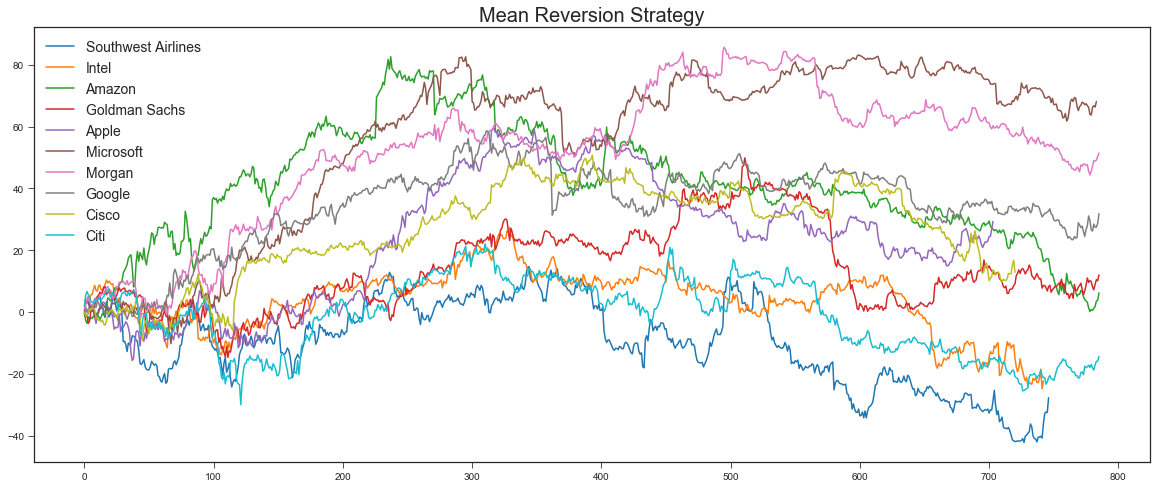

In [17]:


def portfolio_sim_mean(n, portfolio, labels):
    ''' 
    
    A compilation function for the above functions which simulates a portfolio for the securities using the best_indicator function.
    
    Inputs:
    
    n: Number of iterations
    portfolio: Price data for various securities
    labels: Labels for the securities
    
    Returns: 
    
    '''
    
    basket = []
    for i in range(portfolio.shape[1]):
        column = str(labels[i])
        best_sim = best_indicatorMean(n,portfolio[column], column)
        basket.append(best_sim)
        
        
    return basket
plt.figure(figsize=(20,8))
plt.title("Mean Reversion Strategy", fontsize=20)
mean_port = portfolio_sim_mean(1, stock_portfolio, stock_labels)

Benchmark VAR @ confidence Level = 95% Level -0.064
MACD Strategy VAR @ confidence Level = 95% Level -0.008
Total Strategy Return 14.75
Average Yearly ROI = 3.85


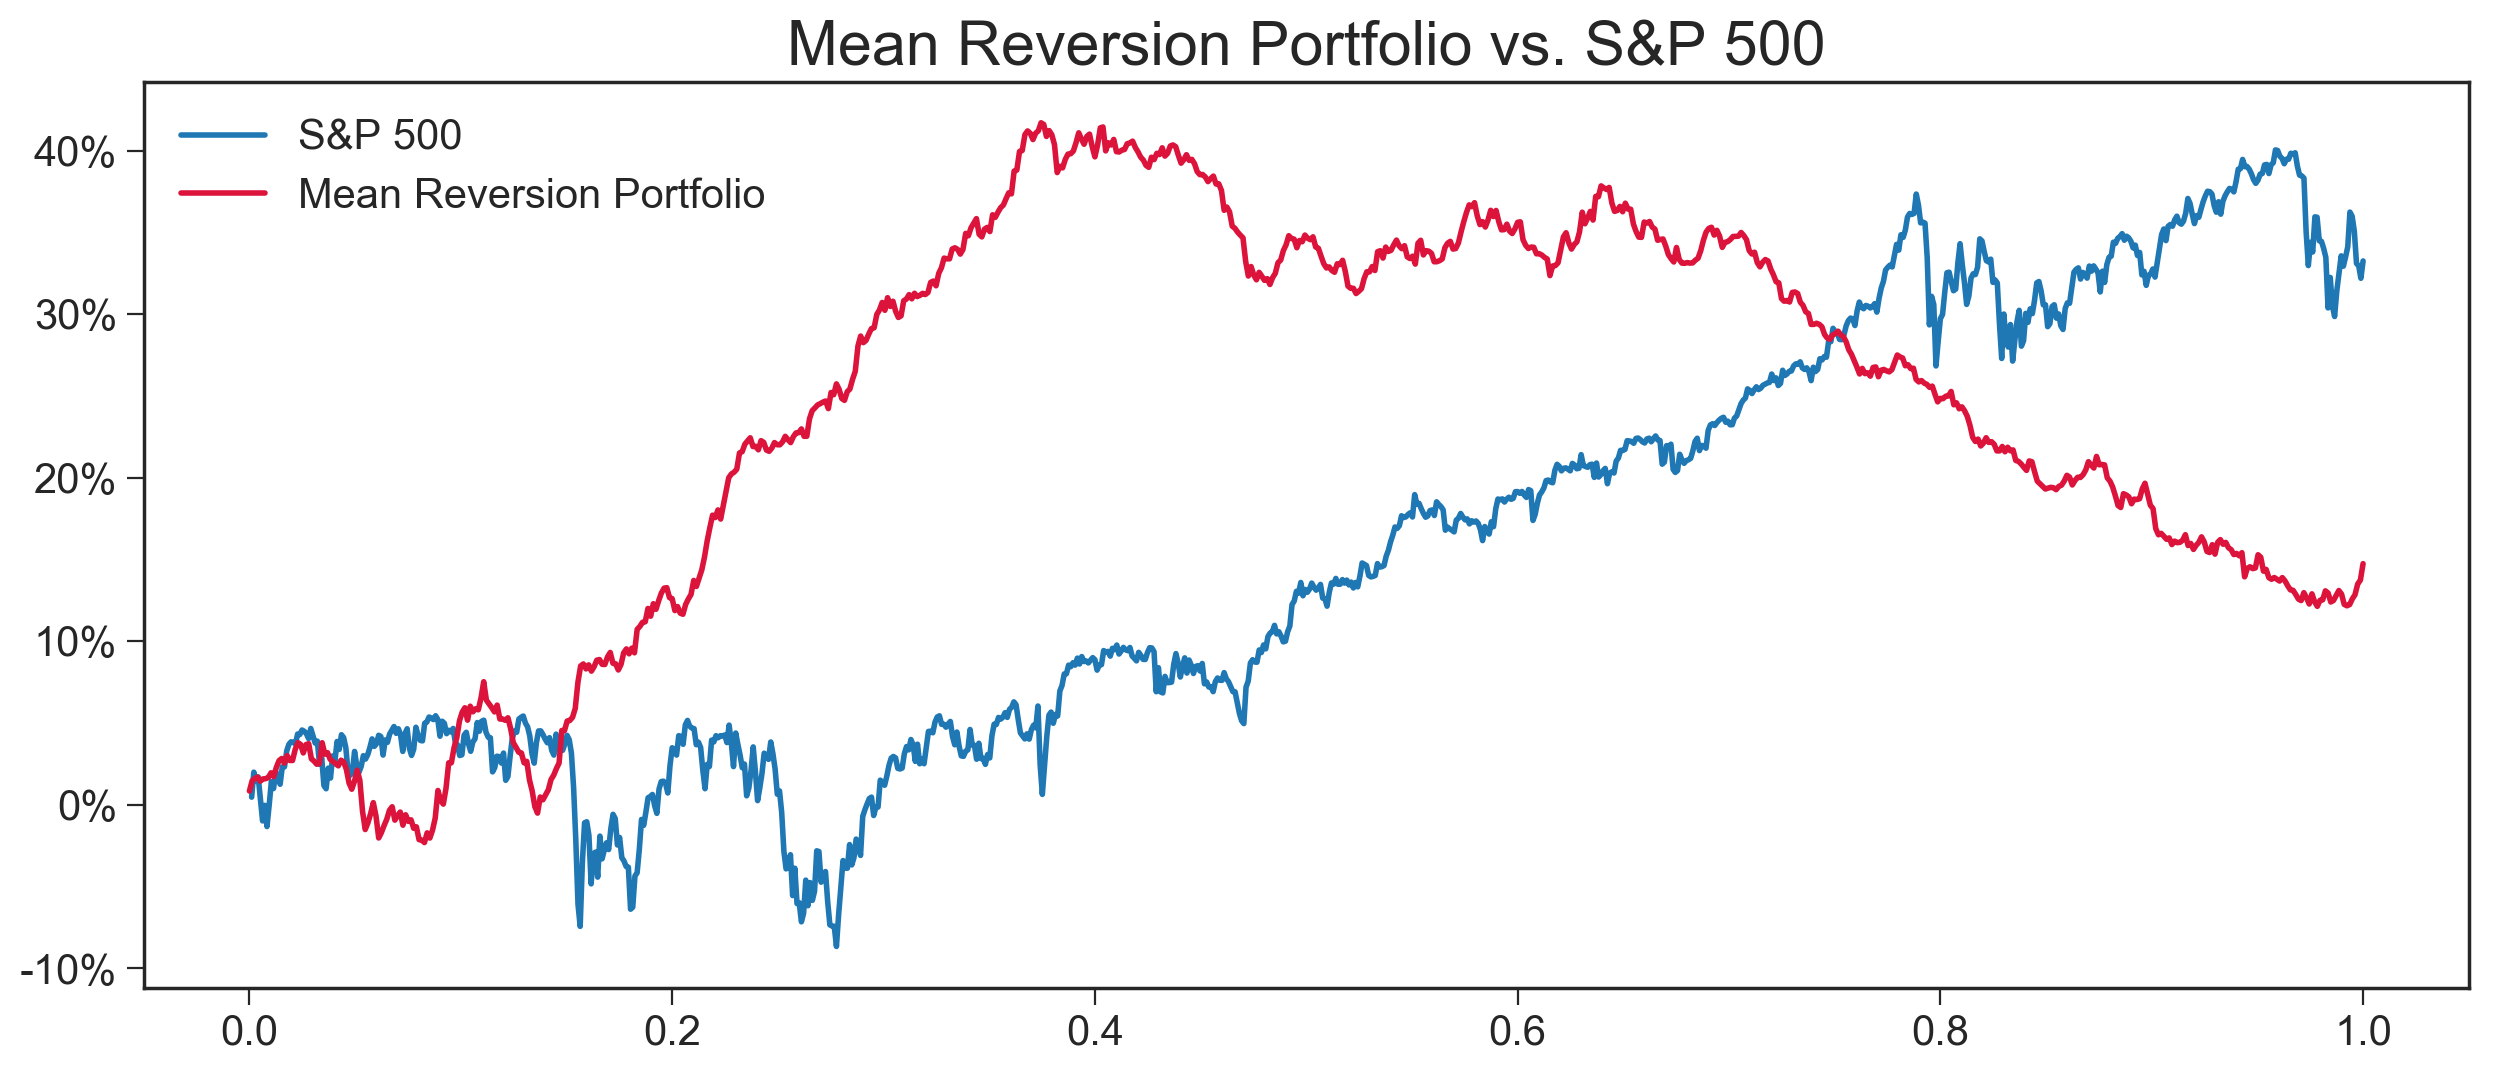

In [18]:
structured_returns = zero(mean_port)
total_returns = combine(structured_returns)
cum_returns = np.cumsum(total_returns)


#RISK ASSESMENT
sp500_returns = np.cumsum(sp500.pct_change()*100)
sp500_mean = np.mean(sp500_returns)/100

sp500_std = np.std(sp500_returns)/100
sp500_VAR = norm.ppf(1-0.95,sp500_mean, sp500_std)
print("Benchmark VAR @ confidence Level = 95% Level", round(sp500_VAR,3))
strategy_mean = np.mean(total_returns)/100

strategy_std = np.std(total_returns)/100
strategy_VAR = norm.ppf(1-0.95,strategy_mean, strategy_std)
print("MACD Strategy VAR @ confidence Level = 95% Level", round(strategy_VAR,3))



roi = cum_returns[-1]/(3.83)
print("Total Strategy Return",round(cum_returns[-1],2))
print("Average Yearly ROI =",round(roi,2))

bench_date = np.linspace(0,1,len(sp500_returns))
strat_date = np.linspace(0,1,len(cum_returns))
fig, ax = plt.subplots(figsize=(15,6),dpi=200)


#Plotting S&P vs Strategy
ax.plot(bench_date, sp500_returns, label="S&P 500",linewidth=2)
ax.plot(strat_date, cum_returns, label = "Mean Reversion Portfolio", linewidth=2,color="crimson")
ax.tick_params(labelsize=15)
ax.set_title("Mean Reversion Portfolio vs. S&P 500",fontsize=22)
ax.yaxis.set_major_formatter(PercentFormatter())



ax.legend(fontsize=15)



plt.savefig("Benchmark.png")

Strategy Return = % 39.547649125233555
Total Return Outright = % 33.25190545349909
Benchmark VAR @ confidence Level = 95% Level -1.3125019761583434
Strategy VAR @ confidence Level = 95% Level -1.211833074908252


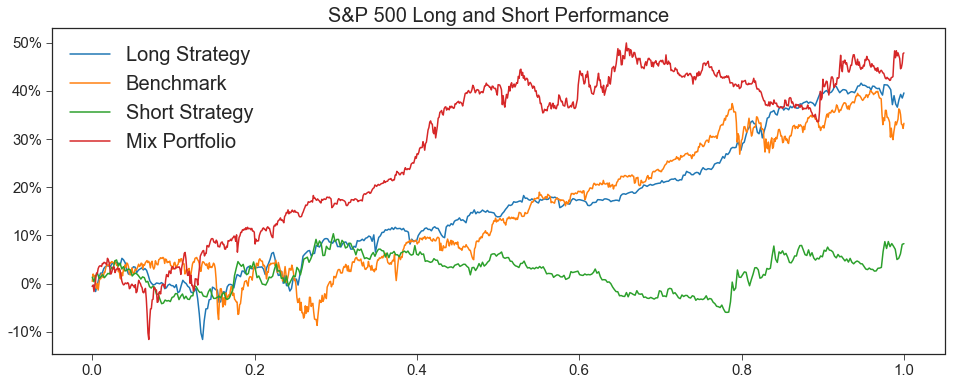

In [19]:
def Individual_stock(price_in,long_indicator,short_indicator):
    
    '''
    Compares the long and short perfomance of an indivdual assets given the long/short indicator.
    Asses risk for benchmark and strategy and plots the perfomance.
    
    '''
    
    
    buys = []
    shorts = []
    rets = []
    s_rets = []
    benchmark = []
    twenty_six = price_in.ewm(span=26).mean()
    twelve = price_in.ewm(span=12).mean()
    macd = twelve - twenty_six
    delta_macd = macd.pct_change(periods=2)
    mix = []
    mix_port = []
    for i in range(len(price_in)-1):
        if delta_macd[i] > long_indicator:
            buys.append(i)
            mix.append(i)
        elif delta_macd[i] < short_indicator:
            shorts.append(i)
            mix.append(i)
    for i in buys:
        j = int(i)
        j1 = int(i+1)
        returns = ((price_in[j1] - price_in[j])/price_in[j])*100
        rets.append(returns)
    for i in shorts:
        s = int(i)
        s1 = int(i+1)
        s_returns = ((price_in[s1] - price_in[s])/price_in[s])*-100
        s_rets.append(s_returns)

        
    for i in range(len(price_in)-1):
        z = int(i)
        z1 = int(i+1)
        base = ((price_in[z1] - price_in[z])/price_in[z])*100
        benchmark.append(base)

    x_bench = np.linspace(0,1,len(benchmark))
    x_strat = np.linspace(0,1,len(rets))   
    x_short = np.linspace(0,1,len(s_rets))
    mix_port = np.concatenate((rets,s_rets))
    x_mix = np.linspace(0,1,len(mix_port))
    fig, ax = plt.subplots(figsize=(16,6))

    ax.plot(x_strat, np.cumsum(rets),label="Long Strategy")
    ax.plot(x_bench, np.cumsum(benchmark),label="Benchmark")
    ax.plot(x_short, np.cumsum(s_rets),label="Short Strategy")
    ax.plot(x_mix, np.cumsum(mix_port),label="Mix Portfolio")
    ax.set_title("S&P 500 Long and Short Performance", fontsize=20)


    ax.yaxis.set_major_formatter(PercentFormatter())
    ax.tick_params(labelsize=15)
    ax.legend(fontsize=20)
    print("Strategy Return = %",sum(rets))
    print("Total Return Outright = %",sum(benchmark))
    
    #RISK ASSESMENT BENCHMARK
    delta_returns = price_in.pct_change()
    mean_returns = np.mean(delta_returns)
    std_returns = np.std(delta_returns)
    VAR_95 = norm.ppf(1-0.95,mean_returns, std_returns)*100
    print("Benchmark VAR @ confidence Level = 95% Level", VAR_95)
    
    #RISK ASSESMENT STRATEGY
    #delta_returns_strat = price_in.pct_change()
    mean_returns_strat = np.mean(rets)
    std_returns_strat = np.std(rets)
    VAR_95_strat = norm.ppf(1-0.95,mean_returns_strat, std_returns_strat)
    print("Strategy VAR @ confidence Level = 95% Level", VAR_95_strat)
    return mix_port

long_ind = random_walker(100,"long",sp500)
short_ind = random_walker(100,"short",sp500)
sp_performance = Individual_stock(sp500,long_ind,short_ind)


# Machine Learing Application

In [20]:
from random import seed
from random import randrange
from csv import reader
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from operator import itemgetter
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

    
''' 
    
    Similiar to other testing functions by testing MACD by calculating MACD for the input data. 
    The difference is this function is shifting the next day returns to be even with the current day
    MACD level. This is so we can create labels for the ML test.
    
    Inputs:
    
    Price_in: Security Prices
    
    Returns: A 2D array with input prices in column 1, Delta_MACD column 2, MACD column 3, and next day
    returns shifted down a line for column 4.
    
'''
def ML_Tester(price_in):
    benchmark = []
    twenty_six = price_in.ewm(span=26).mean()
    twelve = price_in.ewm(span=12).mean()
    macd = twelve - twenty_six
    delta_macd = (macd.pct_change(periods=2))

    for i in range(len(price_in)-1):
        j = int(i)
        j1 = int(i+1)
        returns = ((price_in[j1] - price_in[j])/price_in[j])*100
        benchmark.append(returns)
    x = np.column_stack((benchmark[10:-2],delta_macd[10:-3],macd[10:-3],benchmark[9:-3])) #benchmark 9:-3 is different because
    #That is the next day returns we want even with current day MACD levels.
    return np.array(x)


combined_data = ML_Tester(sp500)

'''
Creates Labels for ML. If the shifted down returns are postive that means if you bought MACD at T=1, then the returns
at T=2 are postive. Which means if we predict a 1, we are predicting that the next day returns will be postive so that
means we purchase at that time.
'''
def Create_Labels(arr):
    binary = []
    one = 1
    zero = 2
    for i in range(len(arr)):
        if arr[:,0][i] > 0:
            binary.append(int(one))
        else:
            binary.append(int(zero))
    return binary

binary = Create_Labels(combined_data)
#Combining labels and features
structured_ML = np.column_stack((combined_data,binary))
print(structured_ML)


[[ -0.4156046   -0.60788644  -1.36194889   1.44394949   2.        ]
 [  1.02914068  -0.84839756  -0.48148453  -0.4156046    1.        ]
 [ -0.34181724  -2.00201689   1.36469579   1.02914068   2.        ]
 ...
 [ -0.91990136  -0.48053305 -17.31960733  -0.25089166   2.        ]
 [ -1.97014893  -0.42992265 -13.79395998  -0.91990136   2.        ]
 [ -0.14819197  -0.11977104 -15.24521989  -1.97014893   2.        ]]


In [21]:
features = structured_ML[:, 1:3]

labels = structured_ML[:,-1]


#Splitting our data into test and training
train, test, train_labels, test_labels = train_test_split(features,
                                                          labels,
                                                          test_size=0.30)
# Initialize our classifier
gnb = GaussianNB()

# Train our classifier
model = gnb.fit(train, train_labels)

# Make predictions
predictions = gnb.predict(test)

print(predictions)
print(test_labels)

# Evaluate accuracy
print("The accuracy of this classifer is",accuracy_score(test_labels, predictions))

'''
If our classifer predicts a 2, meaning that we don't purchase today. And the next day return is positve we didn't
lose any money. We just missed out on potential gains, so we just need to check if we predicted a 1, if the test label 
was a 1 because that means we correctly chose when to buy. And if we predicted 1, and it was 2, that is a loss.

This function is checking the accuracy of only buy oppurtunities.
'''
def eval(predicted,real):
    y = []
    count = 0
    correct = 0
    for i in range(len(predicted)):
        if predicted[i] == 1:
            count += 1
            if real[i] == 1:
                correct += 1
    return round((correct/count),3)
correct_buys = eval(predictions,test_labels)

print("The accuracy of identifying correct buy oppurtunities is",correct_buys)

            
            


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 2. 2. 2. 2. 1. 1. 2. 1. 2. 1. 2. 1. 1. 2. 2. 1. 2. 1. 1. 2. 1. 2. 2.
 2. 1. 2. 2. 2. 1. 2. 2. 2. 1. 1. 1. 2. 1. 2. 1. 1. 1. 1

# Bracket Strategy

The Risk Adjusted Return was:  32.54
The Total Profit was:  $ 1241.53


(None, None)

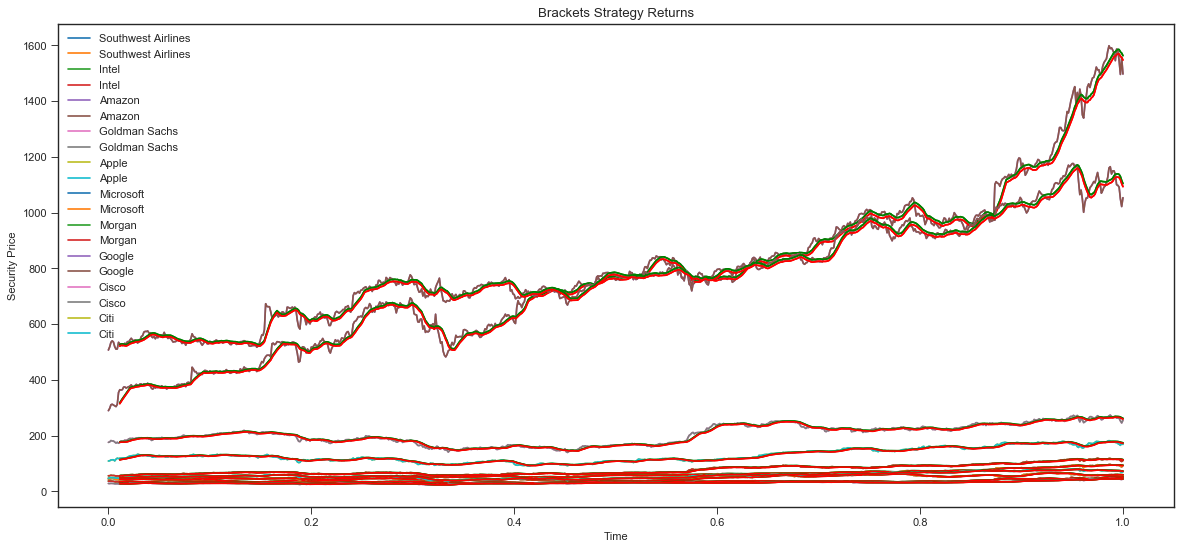

In [22]:
def brackets(stock_price, buy_pct = .995, sell_pct = 1.005, window = 10 ):
    '''
    
    this function takes in a stock price, two percentages (random walk testing has shown that for this dataset, these 
    are the best values), a moving window(10 is a good tradeoff between following trends and ignoring minor fluctuations) 
     and the number of stocks you would like to buy
     
     The buy_pct and sell_pct are the major parameters. The problem is that as with any MLA, (even though this isnt one), 
     the parameters depend entirely on the stock. What yields a high Risk adjusted return for one may give a negative RAR 
     for another. 
    
    '''
    x_stock_price = np.linspace(0,1, len(stock_price)) #make values for the graph
    buys= [] #list of prices bought at
    sells = [] #list of sell prices
    bracket_low = [] #list of the lower bracket prices
    bracket_high = [] #list of the higher bracket prices
    rolling_mean = stock_price.rolling(window=window).mean() #sets up a rolling mean
    x_rolling_mean = np.linspace(0,1,len(rolling_mean)) #makes values for the graph 
    
    
    ''' This basically sets the brackets up up '''
    for i in range(len(rolling_mean)):
        x = buy_pct * rolling_mean[i]
        y = sell_pct * rolling_mean[i]
        bracket_low.append(x)
        bracket_high.append(y) #appending the low and high bracket list prices for plotting and trading purposes
        
    ''' does the trading'''
    for i in range(len(rolling_mean)):
        if stock_price[i] <= bracket_low[i] and len(buys) == len(sells): #only trades amount of stocks_bought at one time
            buys.append(stock_price[i]) #append the stock price bought at 
        if stock_price[i] >= bracket_high[i] and len(buys) > len(sells) :
            sells.append(stock_price[i])#append the stock price sold at
            
            
            ''' calculates return percentages and plots the graphs '''
    returns = []
    profit = []
    for i in range(len(sells)):
        prof = (sells[i]-buys[i])
        rets =( (sells[i] - buys[i])/buys[i]) * 100
        profit.append(prof)
        returns.append(rets) 
    plt.plot(x_stock_price, stock_price) 
    plt.plot(x_stock_price, bracket_high, color = 'green') 
    plt.plot(x_stock_price, bracket_low, color = 'red')
    plt.title("Brackets Strategy Returns")
    plt.ylabel("Security Price")
    plt.xlabel("Time")
    plt.legend()
    ''' this part of the function calculates Risk adjusted return 
    '''
    total_profit = sum(profit)
    total_returns = np.cumsum(returns)
    std_returns = np.std(returns)
    mean_returns = np.mean(returns)
    end_returns1 = total_returns[-1]

    VAR_95 = ((norm.ppf(1-0.95,mean_returns, std_returns)) * -1)/100
    end_return = (end_returns1)
    return np.round(end_return,decimals = 2), np.round(total_profit,  decimals = 2) 
#to get the RISK ADJUSTED RETURN for an individual stock and profit



'''
Dataframe_brackets function is a generalization of the brackets function modified to take in a dataframe of values instead
of a single stock

'''
def dataframe_brackets(data_frame):
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(18, 8), dpi=80, facecolor='w', edgecolor='k') #make the figure large for illustrational purposes
    risk_adjusted_return = []
    profit = []

    for i in data_frame: #take in the dataframe
        risk_adjusted_return.append(brackets(data_frame[i])[0]) #put each column into brackets function and spit out the sum RAR and 
        #cumulative graph 
        profit.append(brackets(data_frame[i])[1])
    total_profit = sum(profit)
    return print("The Risk Adjusted Return was: ",np.round(sum(risk_adjusted_return)/len(risk_adjusted_return),decimals = 2)), print("The Total Profit was:"," $",np.round(total_profit,decimals = 2) ) #print the Average Risk Adjusted Return for all stocks
dataframe_brackets(stock_portfolio)